### Writing a Markov chain / Discrete Markov processes model

In [1]:
from math import gcd
from itertools import combinations
from functools import reduce

import numpy as np
import pandas as pd
import pickle 

In [2]:
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of
            state in the Markov Chain.
        states: 1-D array
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}


    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time
        instance.
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
            self.states,
            p=self.transition_matrix[self.index_dict[current_state], :])


    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states


    def is_accessible(self, i_state, f_state, check_up_to_depth=1000):
        """
        Check if state f_state is accessible from i_state.
        Parameters
        ----------
        i_state: str
            The state from which the accessibility needs to be checked.
        f_state: str
            The state to which accessibility needs to be checked.
        """
        counter = 0
        reachable_states = [self.index_dict[i_state]]
        for state in reachable_states:
            if counter == check_up_to_depth:
                break
            if state == self.index_dict[f_state]:
                return True
            else:
                reachable_states.extend(np.nonzero(self.transition_matrix[state, :])[0])
            counter = counter + 1
        return False


    def is_irreducible(self):
        """
        Check if the Markov Chain is irreducible.
        """
        for (i, j) in combinations(self.states, 2):
            if not self.is_accessible(i, j):
                return False
        return True


    def get_period(self, state, max_number_stps = 50, max_number_trls = 100):
        """
        Returns the period of the state in the Markov Chain.
        Parameters
        ----------
        state: str
            The state for which the period needs to be computed.
        """
        initial_state = state
        max_number_steps = max_number_stps
        max_number_trials = max_number_trls
        periodic_lengths = []
        a= []

        for i in range(1, max_number_steps+1):
            for j in range(max_number_trials):
                last_states_chain = self.generate_states(current_state=initial_state, no=i)[-1]
                if last_states_chain == initial_state:
                    periodic_lengths.append(i)
                    break

        if len(periodic_lengths) >0:
            a = reduce(gcd, periodic_lengths)
            return a


    def is_aperiodic(self):
        """
        Checks if the Markov Chain is aperiodic.
        """
        periods = [self.get_period(state) for state in self.states]
        for period in periods:
            if period != 1:
                return False
        return True


    def is_transient(self, state):
        """
        Checks if a state is transient or not.
        Parameters
        ----------
        state: str
            The state for which the transient property needs to be checked.
        """
        if np.all(self.transition_matrix[~self.index_dict[state], self.index_dict[state]] == 0):
            return True
        else:
            return False

    def is_absorbing(self, state):
        """
        Checks if the given state is absorbing.
        Parameters
        ----------
        state: str
        The state for which we need to check whether it's absorbing
        or not.
        """
        state_index = self.index_dict[state]
        if self.transition_matrix[state_index, state_index] == 1:
            return True
        else:
            return False

#### toy example

In [3]:
transition_matrix = [[0.8, 0.19, 0.01],
                     [0.2,  0.7,  0.1],
                     [0.1,  0.2,  0.7]]
weather_chain = MarkovChain(transition_matrix=transition_matrix, states=['Sunny', 'Rainy', 'Snowy'])

In [4]:
df2 = pd.DataFrame(transition_matrix, columns=['Sunny', 'Rainy', 'Snowy'], index=['Sunny', 'Rainy', 'Snowy'])
df2

,Sunny,Rainy,Snowy
Sunny,0.8,0.19,0.01
Rainy,0.2,0.70,0.10
Snowy,0.1,0.20,0.70


In [5]:
print(weather_chain.next_state(current_state='Sunny'))

print(weather_chain.next_state(current_state='Snowy'))

print(weather_chain.generate_states(current_state='Snowy', no=10))

Sunny
Snowy
['Snowy', 'Sunny', 'Rainy', 'Snowy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny']


### Markov model for MineRL

In [6]:
# LOAD Chains
with open("pickaxe_chains.pkl", "rb") as pkl_handle:
    chains = pickle.load(pkl_handle)
    
    
print('In total, we have {} chains in the task of Obtain IronPickaxe.\n\n'.format(len(chains)))
    
remove = []
for i in chains.keys():
    if chains[i]['time_indexes'][0][0].split('+')[0] != 'log':
        print("----{}----\n{}\n".format(i,chains[i]['time_indexes']))
        remove.append(i)
    if chains[i]['reward']<128:
        if i not in remove:
            remove.append(i)
        
for i in remove:
    del(chains[i])

    
print('We removed chains whose reward below than 128, and those obtained other items before obtaining the log item. Now we have {} chains in total.'.format(len(chains)))

In total, we have 234 chains in the task of Obtain IronPickaxe.


----v3_absolute_zucchini_basilisk-13_13284-14038----
[('dirt+1', 0, 150), ('log+3', 150, 438)]

----v3_absolute_zucchini_basilisk-13_50248-56660----
[('stick+3', 0, 185), ('log+4', 185, 1014), ('dirt+1', 1014, 1048), ('stick+7', 1048, 1618), ('planks+4', 1618, 2003), ('crafting_table+2', 2003, 2190), ('planks+4', 2190, 2335), ('wooden_pickaxe+1', 2335, 2456), ('cobblestone+3', 2486, 2977), ('stone_pickaxe+1', 2977, 3412), ('iron_ore+3', 3441, 3765), ('cobblestone+6', 3765, 3958), ('coal+1', 3958, 4015), ('cobblestone+7', 4015, 4039), ('coal+3', 4039, 4132), ('furnace+1', 4920, 5409), ('iron_ingot+3', 5435, 6167), ('iron_pickaxe+1', 6167, 6332)]

----v3_conscious_tangerine_rain_bird-41_110717-116140----
[('dirt+1', 0, 383), ('log+9', 383, 1883), ('planks+36', 1883, 1955), ('stick+4', 1955, 2037), ('crafting_table+1', 2037, 2137), ('wooden_axe+1', 2137, 2576), ('wooden_pickaxe+1', 2576, 2692), ('planks+24', 2692, 2723), ('

### Making transition matrix

In [7]:
# create a column called 
for trajectory in chains:
    cur_item_chain = []
    for i in chains[trajectory]['time_indexes']:
        cur_item_chain.append(i[0].split('+')[0])
    chains[trajectory]['item_chain'] = cur_item_chain
    
# take out the item_chains
item_chains = []
for trajectory in chains:
    item_chains.append(chains[trajectory]['item_chain'])
    
# add start and termination token   
for i in item_chains:
    i.insert(0,'S')
    i.append('\S')
    
#get ready for the transition matrix
def flatten(t):
    return [item for sublist in t for item in sublist]

new_item_chains = flatten(item_chains)

df = pd.DataFrame(new_item_chains)

# create a new column with data shifted one space
df['shift'] = df[0].shift(-1)

# add a count column (for group by function)
df['count'] = 1


# groupby and then unstack, fill the zeros
trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

trans_matrix = trans_mat.div(trans_mat.sum(axis=1), axis=0).values

In [8]:
trans_mat

count                                                        \
shift               S     \S  coal cobblestone crafting_table  dirt furnace   
0                                                                             
S                 0.0    0.0   0.0         0.0            0.0   0.0     0.0   
\S              191.0    0.0   0.0         0.0            0.0   0.0     0.0   
coal              0.0    0.0  19.0        26.0            4.0   5.0    11.0   
cobblestone       0.0    0.0  38.0         6.0           17.0  30.0    50.0   
crafting_table    0.0    0.0  22.0        78.0            0.0  62.0    15.0   
dirt              0.0    0.0  13.0        82.0            8.0   1.0     2.0   
furnace           0.0    0.0  10.0        24.0            8.0   2.0     3.0   
iron_ingot        0.0    6.0   2.0         1.0            1.0   1.0     3.0   
iron_ore          0.0    3.0  10.0        47.0           13.0   4.0   103.0   
iron_pickaxe      0.0  180.0   0.0         0.0            0.0   0.0     0.0   
log               0.0    1.0   3.0         7.0            8.0  21.0     1.0   
planks            0.0    0.0   2.0         5.0          176.0   9.0     1.0   
stick             0.0    0.0   8.0        18.0           67.0   7.0     0.0   
stone             0.0    2.0  19.0        68.0            4.0  11.0     6.0   
stone_axe         0.0    0.0   0.0         0.0            2.0   0.0     0.0   
stone_pickaxe     0.0    0.0   5.0        48.0           31.0   4.0    16.0   
torch             0.0    0.0  14.0        20.0           11.0   2.0     3.0   
wooden_axe        0.0    0.0   0.0         1.0            6.0   0.0     0.0   
wooden_pickaxe    0.0    0.0   1.0        56.0           82.0  11.0     0.0   

                                                                            \
shift          iron_ingot iron_ore iron_pickaxe    log planks  stick stone   
0                                                                            
S                     0.0      0.0          0.0  192.0    0.0    0.0   0.0   
\S                    0.0      0.0          0.0    0.0    0.0    0.0   0.0   
coal                  3.0     12.0          1.0    0.0    1.0    9.0  10.0   
cobblestone           8.0     61.0          1.0    6.0    4.0   17.0  85.0   
crafting_table        2.0     15.0          2.0   20.0   43.0  127.0  11.0   
dirt                  0.0      9.0          1.0    8.0    6.0    3.0  27.0   
furnace              91.0     30.0          4.0    1.0    6.0   20.0   9.0   
iron_ingot           19.0      2.0        163.0    0.0    5.0    2.0   0.0   
iron_ore             40.0     41.0          1.0    0.0   11.0    6.0  11.0   
iron_pickaxe          1.0      0.0          0.0    0.0    0.0    0.0   0.0   
log                   1.0      1.0          1.0    0.0  213.0    2.0   1.0   
planks               14.0      1.0          2.0   16.0    0.0   94.0   0.0   
stick                20.0     10.0          3.0   10.0   46.0    1.0   1.0   
stone                 1.0     44.0          0.0    0.0    0.0    3.0  40.0   
stone_axe             0.0      0.0          0.0    2.0    1.0    1.0   0.0   
stone_pickaxe         3.0     40.0          0.0    2.0    2.0   41.0   6.0   
torch                 3.0     29.0          2.0    1.0    2.0    2.0  12.0   
wooden_axe            0.0      0.0          0.0    3.0    2.0    2.0   0.0   
wooden_pickaxe        0.0      2.0          0.0    4.0   19.0   27.0   1.0   

                                                                        
shift          stone_axe stone_pickaxe torch wooden_axe wooden_pickaxe  
0                                                                       
S                    0.0           0.0   0.0        0.0            0.0  
\S                   0.0           0.0   0.0        0.0            0.0  
coal                 0.0           9.0  56.0        0.0            0.0  
cobblestone          5.0         149.0   7.0        0.0            3.0  
crafting_table       0.0           7.0  11.0     

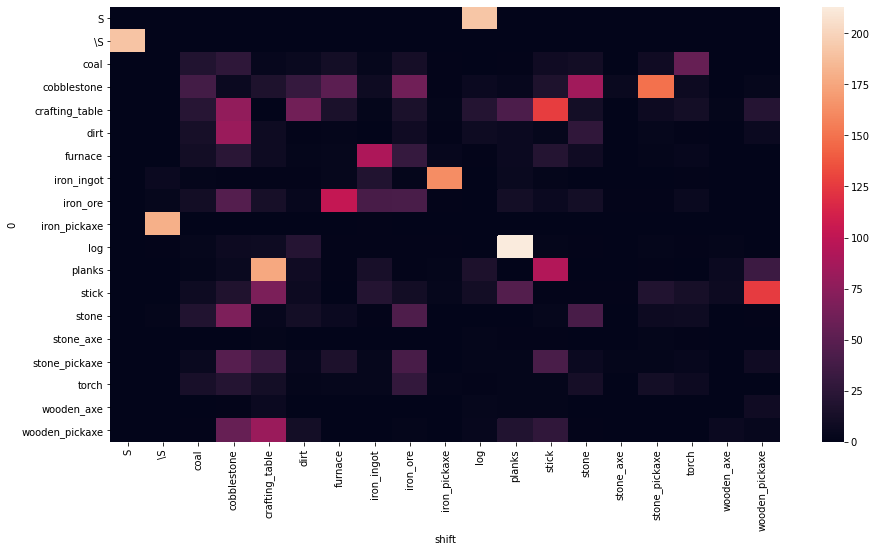

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))

import seaborn as sns
sns.heatmap(trans_mat['count'])

In [10]:
#generate the most greedy chain

index = trans_mat.index

In [11]:
init_state = {
    "inventory":{"log": 0, 
                 "planks": 0,
                 "crafting_table": 0,
                 "stick": 0,
                 "wooden_pickaxe": 0,
                 "dirt": 0,
                 "cobblestone": 0,
                 "stone_pickaxe": 0,
                 "furnace": 0,
                 "iron_ore": 0,
                 "iron_ingot": 0,
                 "iron_pickaxe": 0,
                }}

In [12]:
def obey_transition_rules(cur_inv, next_state):
    """
    Here, we ignore the number of items. Only check the state(item) dependency.
    """
    obey = False
    
    
    # log has no prerequisite
    if next_state == 'log':
         obey = True
    
    # Planks requires log
    if next_state == 'planks':
        if cur_inv['inventory']['log']:
             obey = True
    
    # crafting_table requires Planks
    if next_state == 'crafting_table':
        if cur_inv['inventory']['planks']:
             obey = True

    # stick requires Planks
    if next_state == 'stick':
        if cur_inv['inventory']['planks']:
            obey = True
        
        
    # wooden_pickaxe requires Planks,stick
    if next_state == 'wooden_pickaxe':
        if cur_inv['inventory']['planks']:
            if cur_inv['inventory']['stick']:
                obey = True
    
    if next_state == 'cobblestone':
        if cur_inv['inventory']['wooden_pickaxe']:
            obey = True
            
    if next_state == 'furnace':
        if cur_inv['inventory']['cobblestone']:
            obey = True
            
    if next_state == 'torch':
        if cur_inv['inventory']['coal']:
            if cur_inv['inventory']['stick']:
                obey = True
    
    if next_state == 'stone_pickaxe':
        if cur_inv['inventory']['cobblestone']:
            if cur_inv['inventory']['stick']:
                obey = True
                
    if next_state == 'iron_ore':
        if cur_inv['inventory']['stone_pickaxe']:
            obey = True
                
    if next_state == 'iron_ingot':
        if cur_inv['inventory']['iron_ore']:
            if cur_inv['inventory']['log'] or cur_inv['inventory']['coal']:
                obey = True
                
    if next_state == 'iron_pickaxe':
        if cur_inv['inventory']['iron_ingot']:
            if cur_inv['inventory']['stick']:
                obey = True
                
    return obey

In [13]:
def greedy_path(trans_matrix,trans_mat):
    init_state = {
    "inventory":{"log": False, 
                 "planks": False,
                 "crafting_table": False,
                 "stick": False,
                 "wooden_pickaxe": False,
                 "dirt": False,
                 "cobblestone": False,
                 "stone_pickaxe": False,
                 "furnace": False,
                 "coal": False,
                 "iron_ore": False,
                 "iron_ingot": False,
                 "iron_pickaxe": False,
                }}

    index = trans_mat.index
    path = []
    index_path = []
    cur_inv = init_state
    
    #start from Start trans_matrix[0]
    path.append('S')
    index_path.append(0)
    cur_state = index_path[-1]
    
    done =False
    while done!= True:
        candidates = np.flip(np.argsort(trans_matrix[cur_state]))
        for next_index in candidates:
            next_state = index[next_index]
            if next_state == '\S':
                path.append('\S')
                index_path.append('\S')
                done =True
            if obey_transition_rules(cur_inv, next_state):
                    cur_inv['inventory'][next_state] = True
                    if next_state in path:
                        continue
                    else:
                        path.append(next_state)
                        index_path.append(next_index)
                        cur_state = index_path[-1]
                        break
                        
    return path

In [14]:
path = greedy_path(trans_matrix,trans_mat)
path

['S',
 'log',
 'planks',
 'crafting_table',
 'stick',
 'wooden_pickaxe',
 'cobblestone',
 'stone_pickaxe',
 'iron_ore',
 'furnace',
 'iron_ingot',
 'iron_pickaxe',
 '\\S']